## This assignment is designed for automated pathology detection for Medical Images in a relalistic setup, i.e. each image may have multiple pathologies/disorders. 
### The goal, for you as an MLE, is to design models and methods to predictively detect pathological images and explain the pathology sites in the image data.

## Data for this assignment is taken from a Kaggle contest: https://www.kaggle.com/c/vietai-advance-course-retinal-disease-detection/overview
Explanation of the data set:
The training data set contains 3435 retinal images that represent multiple pathological disorders. The patholgy classes and corresponding labels are: included in 'train.csv' file and each image can have more than one class category (multiple pathologies).
The labels for each image are

```
-opacity (0), 
-diabetic retinopathy (1), 
-glaucoma (2),
-macular edema (3),
-macular degeneration (4),
-retinal vascular occlusion (5)
-normal (6)
```
The test data set contains 350 unlabelled images.

# For this assignment, you are working with specialists for Diabetic Retinopathy and Glaucoma only, and your client is interested in a predictive learning model along with feature explanability and self-learning for Diabetic Retinopathy and Glaucoma vs. Normal images.
# Design models and methods for the following tasks. Each task should be accompanied by code, plots/images (if applicable), tables (if applicable) and text:
## Task 1: Build a classification model for Diabetic Retinopathy and Glaucoma vs normal images. You may consider multi-class classification vs. all-vs-one classification. Clearly state your choice and share details of your model, paremeters and hyper-paramaterization pprocess. (60 points)
```
a. Perform 70/30 data split and report performance scores on the test data set.
b. You can choose to apply any data augmentation strategy. 
Explain your methods and rationale behind parameter selection.
c. Show Training-validation curves to ensure overfitting and underfitting is avoided.
```
## Task 2: Visualize the heatmap/saliency/features using any method of your choice to demonstrate what regions of interest contribute to Diabetic Retinopathy and Glaucoma, respectively. (25 points)
```
Submit images/folder of images with heatmaps/features aligned on top of the images, or corresponding bounding boxes, and report what regions of interest in your opinion represent the pathological sites.
```

## Task 3: Using the unlabelled data set in the 'test' folder augment the training data (semi-supervised learning) and report the variation in classification performance on test data set.(15 points)
[You may use any method of your choice, one possible way is mentioned below.] 

```
Hint: 
a. Train a model using the 'train' split.
b. Pass the unlabelled images through the trained model and retrieve the dense layer feature prior to classification layer. Using this dense layer as representative of the image, apply label propagation to retrieve labels correspndng to the unbalelled data.
c. Next, concatenate the train data with the unlabelled data (that has now been self labelled) and retrain the network.
d. Report classification performance on test data
Use the unlabelled test data  to improve classification performance by using a semi-supervised label-propagation/self-labelling approach. (20 points)
```
## Good Luck!

In [1]:
# Import statements.
import os
import math
import numpy as np
import pandas
from typing import Any, Dict, List, Optional
from datetime import datetime
import cv2
import matplotlib
import matplotlib.pyplot as plt
from sklearn.semi_supervised import LabelSpreading
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import History, TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, \
    Dropout, BatchNormalization, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import GradientTape
from tensorflow.keras import backend as K
from tensorflow import reduce_mean, multiply

In [2]:
# Global constants.
DEFAULT_ROOT_DIR = os.path.join('.', 'Data')
DEFAULT_DATASET_ARGS = {'val_split': 0.3}
DEFAULT_MODEL_ARGS = {'input_shape': (256, 256, 3),
                      'output_shape': (3,),
                      'learning_rate': 1e-4}
DEFAULT_TRAIN_ARGS = {'epochs': 5,
                      'batch_size': 32,
                      'shuffle': True,
                      'use_tensorboard': False,
                      'model_checkpoint_filename': None,
                      'augment': False}
METRICS = {'accuracy', 'precision', 'recall', 'F1'}
DEFAULT_CLASS_NAMES = ['normal', 'diabetic retinopathy', 'glaucoma']
TRAIN_KEY = 'train'
VAL_KEY = 'val'
TEST_KEY = 'test'

In [3]:
# Your drive might be named 'gdrive' rather than 'drive'
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/Midterm/')
os.listdir('.')

Mounted at /content/drive


['Data',
 'logs_2020-12-18 22:37:50.741085',
 'vanilla_alexnet_model.h5',
 'logs_2020-12-18 23:08:33.686611',
 'logs_2020-12-18 23:49:13.330065',
 'logs_2020-12-18 23:49:50.994157',
 'logs_2020-12-18 23:50:20.952624',
 'logs_2020-12-18 23:50:57.546345',
 'logs_2020-12-18 23:53:08.738999',
 'logs_2020-12-18 23:54:00.544689',
 'logs_2020-12-18 23:55:18.001668',
 'logs_2020-12-18 23:55:50.050591',
 'logs_2020-12-18 23:57:37.872727',
 'logs_2020-12-20 19:41:04.014351',
 'vgg_like_model.h5',
 'vgg_like_reg_model.h5',
 'logs_2020-12-21 04:28:42.380931',
 'model.h5',
 'ML_for_Computer_Vision.ipynb']

# Task 1

## Approach

We will use a convolutional neural network with a 3-neuron sigmoid output. We make this choice of model because:

* Convolutional neural networks are the state of the art in image classification problems, in almost every domain.
* A 3-neuron sigmoid output (i.e., multi-label classification) is easy to implement for a neural network, and also allows us to quickly extend the model to 2, 7, or any arbitrary number of outputs.

## Functions

Below are the functions we will use to work with the dataset and run the model.

In [4]:
def load_image_into_numpy_array(path: str) -> np.ndarray:
    """Load an image from file into a numpy array.
    :param path: The path to the image.
    :return: The image contents as an np.ndarray of type uint8.
    """
    img_data = cv2.imread(path)
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
    (width, height) = img_data.shape[:2]
    return img_data.reshape((height, width, 3)).astype(np.uint8)

In [5]:
def normalize_image(img: np.ndarray) -> np.ndarray:
    """Returns the normalized image from the numpy array.
    :param img: The image to normalize, each element of which is np.uint8.
    :return: The normalized image, each element of which is np.float32.
    """
    if img.dtype != np.uint8:
        raise ValueError('Expected image array type np.uint8, but found {0}'
        .format(img.dtype))
    return img.astype(np.float32) / 255

In [6]:
def denormalize_image(norm_img: np.ndarray) -> np.ndarray:
    """Returns the denormalized image (i.e., inverts the normalization process)
    so that the output is a numpy array representing an image.
    :param norm_img: The image to denormalize, each element of which is
    np.float32.
    :return: The denormalized image, each element of which is np.uint8.
    """
    if norm_img.dtype != np.float32:
        raise ValueError('Expected normalized image array type np.float32,'
        'but found {0}'.format(img.dtype))
    return (img * 255).astype(np.uint8)

### A note on labels

One decision we make on labels for this problem is that we do not force the labels for each example to contain at least one 1. In other words, it is possible for the label for an example to be (0, 0, 0), which means that the eye has no glaucoma, no retinopathy, and is not normal.

In [7]:
def get_partition(root_dir: str, dataset_args: Dict[str, Any]) -> \
    Dict[str, List[str]]:
    """Returns a dict where the keys are 'train', 'test', and 'val', and the
    values are the images under each. The list is the authoratative order of the
    train/test examples; partition['train'][0] is the first training example,
    and x_train[0] will correspond with that filename.
    :param root_dir: The root directory of the dataset, in which are located
    test and train subdirectories.
    :param dataset_args: The dataset arguments. See DEFAULT_DATASET_ARGS for
    available options.
    :return: The train/val/test partition.
    """
    dataset_args = {**DEFAULT_DATASET_ARGS, **dataset_args}
    partition = {}
    train_image_dir = os.path.join(root_dir, 'train', 'train')
    train_image_filenames = [filename for
                             filename in os.listdir(train_image_dir) if
                             filename.endswith('.jpg')]
    rand_indices = np.random.permutation(len(train_image_filenames))
    split_index = int(dataset_args['val_split'] * len(train_image_filenames))
    val_indices = rand_indices[:split_index]
    train_indices = rand_indices[split_index:]
    partition[TRAIN_KEY] = [train_image_filenames[i] for i in train_indices]
    partition[VAL_KEY] = [train_image_filenames[i] for i in val_indices]
    test_image_dir = os.path.join(root_dir, 'test', 'test')
    test_image_filenames = [filename for
                            filename in os.listdir(test_image_dir) if
                            filename.endswith('.jpg')]
    partition[TEST_KEY] = test_image_filenames
    return partition

In [8]:
def get_labels(root_dir: str, class_names: List[str]) -> Dict[str, np.ndarray]:
    """Returns a dict where the keys are the image filenames and the values are
    the labels. Each label has classes in the order of class_names (e.g.,
    ['normal', 'diabetic retinopathy', 'glaucoma']).
    :param root_dir: The root directory of the dataset, in which are located
    test and train subdirectories.
    :param class_names: The names of the classes, in order.
    :return: The label dict.
    """
    labels = {}
    train_labels_filename = os.path.join(root_dir, 'train', 'train.csv')
    df_train = pandas.read_csv(train_labels_filename)[['filename'] +
                                                      class_names]
    for i, filename in enumerate(df_train['filename']):
        row = df_train.iloc[i]
        labels[filename] = np.array([row[class_name] for 
                                     class_name in class_names],
                                    dtype=np.float32)
    return labels

In [9]:
def _get_dataset_from_scratch(
    root_dir: str,
    partition: Dict[str, str],
    labels: Dict[str, np.ndarray]) -> (np.ndarray, np.ndarray, np.ndarray,
                                       np.ndarray):
    """Preprocesses and returns the dataset located at root_dir.
    :param root_dir: The root directory of the dataset, in which are located
    test and train subdirectories.
    :param partition: The train/test partition.
    :param labels: The labels.
    :return: The preprocessed dataset as a 4-tuple: x_train, y_train, x_test,
    y_test.
    """
    train_image_dir = os.path.join(root_dir, 'train', 'train')
    first_image = load_image_into_numpy_array(os.path.join(
        train_image_dir, partition[TRAIN_KEY][0]))
    input_shape = (len(partition[TRAIN_KEY]), *first_image.shape)
    print('Inferring training input shape: {0}'.format(input_shape))
    x_train = np.zeros(input_shape, dtype=np.float32)
    y_train = np.zeros((input_shape[0], len(labels[partition[TRAIN_KEY][0]])))
    for i, filename in enumerate(partition[TRAIN_KEY]):
        if i % 100 == 0:
            print('Loading image {0}'.format(i))
        img_arr = load_image_into_numpy_array(os.path.join(
            train_image_dir, filename))
        preprocessed_arr = normalize_image(img_arr)
        x_train[i, :] = preprocessed_arr
        y_train[i, :] = labels[filename]
    test_image_dir = os.path.join(root_dir, 'test', 'test')
    first_image = load_image_into_numpy_array(os.path.join(
        test_image_dir, partition[TEST_KEY][0]))
    input_shape = (len(partition[TEST_KEY]), *first_image.shape)
    if input_shape[1:] != x_train.shape[1:]:
        raise ValueError('Expected test set shape, {0}, to match train set'
        'shape, {1}.'.format(input_shape, x_train.shape))
    print('Inferring test input shape: {0}'.format(input_shape))
    x_test = np.zeros(input_shape, dtype=np.float32)
    y_test = None
    for i, filename in enumerate(partition[TEST_KEY]):
        if i % 100 == 0:
            print('Loading image {0}'.format(i))
        img_arr = load_image_into_numpy_array(os.path.join(
            test_image_dir, filename))
        preprocessed_arr = normalize_image(img_arr)
        x_test[i, :] = preprocessed_arr
    return x_train, y_train, x_test, y_test

In [10]:
def get_dataset(
    root_dir: str,
    partition: Dict[str, str],
    labels: Dict[str, np.ndarray]) -> (np.ndarray, np.ndarray, np.ndarray,
                                       np.ndarray):
    """Preprocesses and returns the dataset located at root_dir. If the cached
    dataset files are available, uses those.
    :param root_dir: The root directory of the dataset, in which are located
    test and train subdirectories.
    :param partition: The train/test partition.
    :param labels: The labels.
    :return: The preprocessed dataset as a 4-tuple: x_train, y_train, x_test,
    y_test.
    """
    # This method results in faster training, but takes so much RAM that we
    # cannot do it with the full dataset.
    return _get_dataset_from_scratch(root_dir, partition, labels)

In [11]:
def _get_alex_net(model_args: Dict[str, Any]) -> Model:
    """Returns AlexNet as a tensorflow.keras.models.Model instance.
    :param model_args: Model hyperparameters. See DEFAULT_MODEL_ARGS for
    hyperparameters and their default values.
    :return: A tensorflow.keras.models.Model instance.
    """
    model = Sequential()
    model.add(Conv2D(96, kernel_size=(11, 11), strides=4,
                     padding='valid', activation='relu',
                     input_shape=model_args['input_shape'],
                     kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2),
                           padding='valid', data_format=None))
    model.add(Conv2D(256, kernel_size=(5, 5), strides=1,
                     padding='same', activation='relu',
                     kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2),
                           padding='valid', data_format=None)) 
    model.add(Conv2D(384, kernel_size=(3, 3), strides=1,
                     padding='same', activation= 'relu',
                     kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(384, kernel_size=(3, 3), strides=1,
                     padding='same', activation='relu',
                     kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=(3, 3), strides=1,
                     padding='same', activation='relu',
                     kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2),
                           padding='valid', data_format=None))
    model.add(Flatten())
    if len(model_args['output_shape']) != 1:
        raise ValueError('Expected last layer to be flat, but found shape {0}'
        .format(len(model_args['output_shape'])))
    model.add(Dense(model_args['output_shape'][0], activation='sigmoid'))
    model.compile(
        optimizer=Adam(learning_rate=model_args['learning_rate']),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [12]:
def _get_vgg_like(model_args: Dict[str, Any]) -> Model:
    """Returns a VGG-like network as a tensorflow.keras.models.Model instance.
    :param model_args: Model hyperparameters. See DEFAULT_MODEL_ARGS for
    hyperparameters and their default values.
    :return: A tensorflow.keras.models.Model instance.
    """
    model = Sequential()
    # Image: 256 x 256
    model.add(Conv2D(64, kernel_size=(3, 3), strides=1,
                     padding='same', activation='relu',
                     input_shape=model_args['input_shape']))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=1,
                     padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # Image: 128 x 128
    model.add(Conv2D(128, kernel_size=(3, 3), strides=1,
                     padding='same', activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), strides=1,
                     padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # Image: 64 x 64
    model.add(Conv2D(256, kernel_size=(3, 3), strides=1,
                     padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), strides=1,
                     padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # Image: 32 x 32
    model.add(Conv2D(512, kernel_size=(3, 3), strides=1,
                     padding='same', activation='relu'))
    model.add(Conv2D(512, kernel_size=(3, 3), strides=1,
                     padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    # Image: 16 x 16
    model.add(Conv2D(512, kernel_size=(3, 3), strides=1,
                     padding='same', activation='relu'))
    model.add(Conv2D(512, kernel_size=(3, 3), strides=1,
                     padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # Image: 8 x 8
    model.add(Flatten())
    #model.add(Dense(4, activation='relu'))
    
    if len(model_args['output_shape']) != 1:
        raise ValueError('Expected last layer to be flat, but found shape {0}'
        .format(len(model_args['output_shape'])))
    model.add(Dense(model_args['output_shape'][0], activation='sigmoid'))
    model.compile(
        optimizer=Adam(learning_rate=model_args['learning_rate']),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [13]:
def _get_vgg_like_regularized(model_args: Dict[str, Any]) -> Model:
    """Returns a VGG-like network as a tensorflow.keras.models.Model instance.
    :param model_args: Model hyperparameters. See DEFAULT_MODEL_ARGS for
    hyperparameters and their default values.
    :return: A tensorflow.keras.models.Model instance.
    """
    model = Sequential()
    # Image: 256 x 256
    model.add(Conv2D(64, kernel_size=(3, 3), strides=1,
                     padding='same', activation='relu',
                     input_shape=model_args['input_shape']))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=1,
                     padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # Image: 128 x 128
    model.add(Conv2D(128, kernel_size=(3, 3), strides=1,
                     padding='same', activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), strides=1,
                     padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # Image: 64 x 64
    model.add(Conv2D(256, kernel_size=(3, 3), strides=1,
                     padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), strides=1,
                     padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # Image: 32 x 32
    model.add(Conv2D(512, kernel_size=(3, 3), strides=1,
                     padding='same', activation='relu'))
    model.add(Conv2D(512, kernel_size=(3, 3), strides=1,
                     padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    # Image: 16 x 16
    model.add(Conv2D(512, kernel_size=(3, 3), strides=1,
                     padding='same', activation='relu'))
    model.add(Conv2D(512, kernel_size=(3, 3), strides=1,
                     padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # Image: 8 x 8
    model.add(Flatten())
    #model.add(Dense(4, activation='relu'))
    
    if len(model_args['output_shape']) != 1:
        raise ValueError('Expected last layer to be flat, but found shape {0}'
        .format(len(model_args['output_shape'])))
    model.add(Dense(model_args['output_shape'][0], activation='sigmoid'))
    model.compile(
        optimizer=Adam(learning_rate=model_args['learning_rate']),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [14]:
def get_model(model_args: Dict[str, Any]) -> Model:
    """Returns a tensorflow.keras.models.Model instance for this dataset.
    :param model_args: Model hyperparameters. See DEFAULT_MODEL_ARGS for
    hyperparameters and their default values.
    :return: A tensorflow.keras.models.Model instance.
    """
    model_args = {**DEFAULT_MODEL_ARGS, **model_args}
    return _get_vgg_like(model_args)

In [15]:
def train_model(model: Model,
                partition: Dict[str, List[str]],
                labels: Dict[str, np.ndarray],
                train_args: Dict[str, Any],
                root_dir: Optional[str],
                class_names: List[str]) -> History:
    """Trains the model and returns the History object that results.
    :param model: The model.
    :param partition: The train/val/test partition.
    :param labels: The labels.
    :param train_args: Training hyperparameters. See DEFAULT_TRAIN_ARGS for
    hyperparameters and their default values.
    :param root_dir: The root directory of the dataset, in which are located
    test and train subdirectories. If None, treat filenames as complete paths.
    :param class_names: The names of the classes, in order.
    :return: The History object that results from calling model.fit().
    """
    train_args = {**DEFAULT_TRAIN_ARGS, **train_args}
    df_train = pandas.DataFrame()
    df_train['filename'] = partition[TRAIN_KEY]
    for i, class_name in enumerate(class_names):
        df_train[class_name] = [labels[filename][i]
                                for filename in partition[TRAIN_KEY]]
    df_val = pandas.DataFrame()
    df_val['filename'] = partition[VAL_KEY]
    for i, class_name in enumerate(class_names):
        df_val[class_name] = [labels[filename][i]
                              for filename in partition[VAL_KEY]]
    if train_args['augment']:
        image_datagen = ImageDataGenerator(
            rotation_range=10.,
            width_shift_range=0.05,
            height_shift_range=0.05,
            zoom_range=0.2,
            channel_shift_range=0.05,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='constant',
            data_format='channels_last',
            rescale=1 / 255)
    else:
        image_datagen = ImageDataGenerator(
            data_format='channels_last',
            rescale=1 / 255)
    train_image_dir = os.path.join(root_dir, 'train',
                                   'train') if root_dir else '.'
    train_generator = image_datagen.flow_from_dataframe(
        df_train,
        directory=train_image_dir,
        x_col='filename',
        y_col=class_names,
        target_size=model.input_shape[1:3],
        class_mode='raw',
        batch_size=train_args['batch_size'],
        shuffle=train_args['shuffle'],
        validate_filenames=False)
    val_generator = image_datagen.flow_from_dataframe(
        df_val,
        directory=train_image_dir,
        x_col='filename',
        y_col=class_names,
        target_size=model.input_shape[1:3],
        class_mode='raw',
        batch_size=train_args['batch_size'],
        shuffle=train_args['shuffle'],
        validate_filenames=False)
    callbacks = []
    if train_args['use_tensorboard']:
        log_dir = 'logs_{0}'.format(datetime.now())
        tensorboard_callback = TensorBoard(log_dir=log_dir)
        callbacks.append(tensorboard_callback)
    if train_args['model_checkpoint_filename']:
        checkpoint_callback = ModelCheckpoint(
            train_args['model_checkpoint_filename'],
            save_best_only=True)
        callbacks.append(checkpoint_callback)
    return model.fit(
        x=train_generator,
        epochs=train_args['epochs'],
        callbacks=callbacks,
        validation_data=val_generator,
        steps_per_epoch=math.ceil(len(partition[TRAIN_KEY]) /
                                  train_args['batch_size']),
        validation_steps=math.ceil(len(partition[VAL_KEY]) /
                                   train_args['batch_size']))

In [16]:
def eval_model(model: Model,
               partition: Dict[str, List[str]],
               labels: Dict[str, np.ndarray],
               class_names: List[str],
               root_dir: str,
               metric: str = 'accuracy') -> float:
    """Returns the model's performance on the val set as a single metric. We
    would use the test set, but there are no labels.
    :param model: The model.
    :param partition: The parition.
    :param labels: The labels.
    :param class_names: The names of the classes, in order.
    :param root_dir: The root directory of the dataset, in which are located
    test and train subdirectories.
    :param metric: The metric to use. One of METRICS (e.g., 'accuracy').
    :return: The model's performance as a single metric.
    """
    if metric not in METRICS:
        raise ValueError('Expected metric to be one of {0}, but found {1}'
        .format(METRICS, metric))
    df_val = pandas.DataFrame()
    df_val['filename'] = partition[VAL_KEY]
    for i, class_name in enumerate(class_names):
        df_val[class_name] = [labels[filename][i]
                              for filename in partition[VAL_KEY]]
    image_datagen = ImageDataGenerator(
        data_format='channels_last',
        rescale=1 / 255)
    train_image_dir = os.path.join(root_dir, 'train', 'train')
    eval_batch_size = 32
    val_generator = image_datagen.flow_from_dataframe(
        df_val,
        directory=train_image_dir,
        x_col='filename',
        y_col=class_names,
        target_size=model.input_shape[1:3],
        class_mode='raw',
        batch_size=eval_batch_size,
        shuffle=False,
        validate_filenames=False)
    result = model.evaluate(
        x=val_generator,
        steps=math.ceil(len(partition[VAL_KEY]) / eval_batch_size),
        return_dict=True)
    return result[metric]

In [17]:
def smooth_curve(points: List[float], factor: float = 0.6) -> List[float]:
    """Returns points smoothed over an exponential.
    :param points: The points of the curve to smooth.
    :param factor: The smoothing factor.
    :return: The smoothed points.
    """
    smoothed_points = []
    for point in points:
        if smoothed_points:
            prev = smoothed_points[-1]
            smoothed_points.append(prev * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [18]:
def plot_history(history: History, smooth_fac: float = 0.6) -> None:
    """Plots the training history. You can also visualize the training process
    in Tensorboard or wandb.
    :param history: The training history.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, smooth_curve(acc, factor=smooth_fac), 'bo',
             label='Smoothed training acc')
    plt.plot(epochs, smooth_curve(val_acc, factor=smooth_fac), 'b',
             label='Smoothed validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
    plt.plot(epochs, smooth_curve(val_loss), 'b',
             label='Smoothed validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

## Experiments

Below we run experiments on the dataset.

In [19]:
partition = get_partition(DEFAULT_ROOT_DIR, DEFAULT_DATASET_ARGS)
labels = get_labels(DEFAULT_ROOT_DIR, DEFAULT_CLASS_NAMES)
print('Found {0} training images, {1} val images, {2} test images.'.format(
    len(partition[TRAIN_KEY]), len(partition[VAL_KEY]),
    len(partition[TEST_KEY])))
print('Found {0} labels.'.format(len(labels.keys())))

Found 2405 training images, 1030 val images, 350 test images.
Found 3435 labels.


In [20]:
# Define hyperparameters.
model_args = {'learning_rate': 1e-4}
train_args = {'epochs': 50,
              'batch_size': 32,
              'shuffle': True,
              'use_tensorboard': True,
              'model_checkpoint_filename': 'model.h5',
              'augment': False}
metric = 'accuracy'

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
dropout (Dropout)            (None, 256, 256, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     1

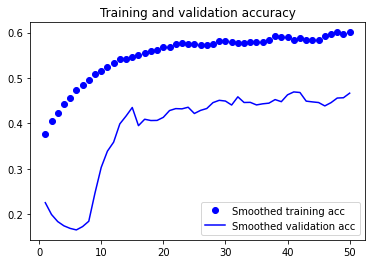

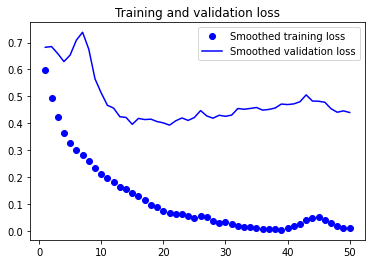

In [ ]:
model = get_model(model_args)
print(model.summary())
history = train_model(model, partition, labels, train_args, DEFAULT_ROOT_DIR,
                      DEFAULT_CLASS_NAMES)
plot_history(history)

In [ ]:
score = eval_model(model, partition, labels, DEFAULT_CLASS_NAMES,
                   DEFAULT_ROOT_DIR, metric=metric)
print('Model score on val data ({0}): {1}'.format(metric, score))

Found 1030 non-validated image filenames.
33/33 [==============================] - 7s 187ms/step - loss: 0.1276 - accuracy: 0.5184
Model score on val data (accuracy): 0.537864089012146


## Task 1 Results

### Metric

For this problem, we choose to evaluate our model on accuracy. Generally, in the medical domain we prefer recall as a metric, but based on the way we have defined our labels, it is not clear how we should measure recall (there are multiple positive classes, but a 0 label in the negative class also indicates the presence of an abnormality). We could create a more complex custom metric, but for that we would want to consult domain experts. It's also very easy to change the metric later.

### Augmentation

Augmentation is very slow (at least using ImageDataGenerator.flow_from_dataframe()), increasing training time per epoch by a factor of 6 (30 to 180 seconds) in our experiments. For such a high cost, augmentation had better result in a much increased metric. We find that it did not result in a large enough performance improvement to justify the sizable time penalty.

Our choices for data augmentation parameters were influenced by previous work we had done on retina scans. We used the parameters we had used before and did not see much improvement. We did not have time to experiment further.

|Augmentation?|Best Model Train Accuracy|Best Model Val Accuracy|
|-|-|-|
|No|0.6236|0.5223|
|Yes|0.4549|0.5214|

### Hyperparameter tuning

Below are the results of our hyperparameter tuning. We only trained a few models due to time and hardware constraints.

|Model|Train Accuracy|Val Accuracy|
|-|-|-|
|AlexNet, no augmentation|0.5839|0.4961|
|AlexNet, with augmentation|0.4549|0.5214|
|VGG-like, no augmentation|0.6236|0.5223|
|VGG-like, no augmentation, dropout|0.5556|0.4631|

### Underfitting/overfitting

Initial models produced the following curves from training. To determine the extent to which we underfit/overfit, we will look at the difference between the training and validation curves. For the sake of argument, we estimate optimal accuracy at 70% (we would need to get this number from a domain expert).

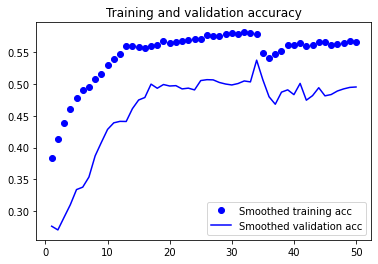
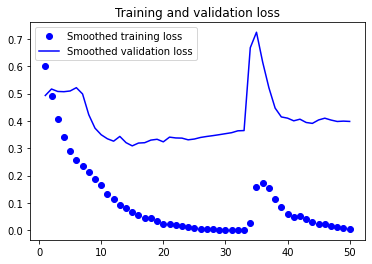

|Theoretical Optimal Accuracy|Training Accuracy|Avoidable Bias (Underfitting)|Val Accuracy|Variance (Overfitting)|
|-|-|-|-|-|
|70%|58%|12%|50%|8%|

Based on these numbers, our initial model is underfitting by 12% and overfitting by 8%. We have a high bias problem, and a moderately high variance problem. From the figures, we can also see that we are effectively minimizing loss on the training set, and begin seriously overfitting after 12 epochs or so. First, we should address bias by training a larger, more complex model. Then we can address variance by adding regularization like dropout and weight decay.

Due to time and hardware constraints, we can only try a few models to address these issues.

Our larger model used a VGG-like architecture and achieved superior performance.

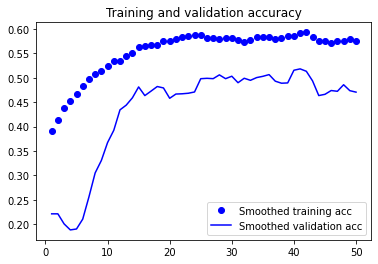
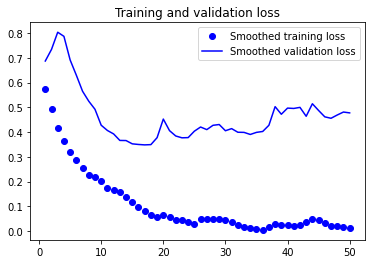

|Theoretical Optimal Accuracy|Training Accuracy|Avoidable Bias (Underfitting)|Val Accuracy|Variance (Overfitting)|
|-|-|-|-|-|
|70%|62%|8%|52%|10%|

Now we add regularization in the form of dropout. Batch normalization layers also play a small regularization role.

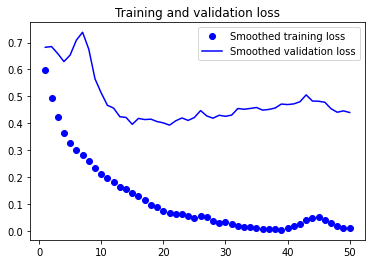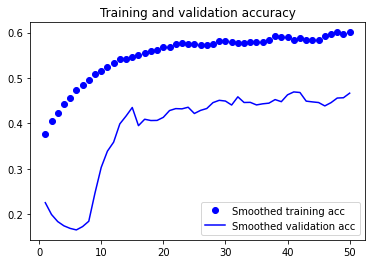

|Theoretical Optimal Accuracy|Training Accuracy|Avoidable Bias (Underfitting)|Val Accuracy|Variance (Overfitting)|
|-|-|-|-|-|
|70%|56%|14%|46%|10%|

In this case, dropout was not any more successful than just batch normalization, but further tuning and experimentation is necessary to identify the correct approach.

# Task 2

## Approach

We will use GradCam to visualize the activations of the last convolutional layer of the neural network.

In [21]:
# If necessary, retrieve the best model.
model = get_model(model_args)
model.load_weights('vgg_like_model.h5')

In [22]:
def predict_on_image(model: Model, filename: str) -> np.ndarray:
    """Returns the model's prediction on the image at filename.
    :param Model: The model.
    :param filename: The path to the image.
    :return: The model's predictions on the image.
    """
    img_arr = load_image_into_numpy_array(filename)
    norm_img = normalize_image(img_arr)
    x = cv2.resize(norm_img, model.input_shape[1:3])
    x = np.expand_dims(x, axis=0)
    return model.predict(x)[0]

In [23]:
def get_last_conv_layer(model: Model) -> Optional[Layer]:
    """Returns the last 2D convolutional layer in the model.
    :param model: The model.
    :return: The last 2D convolutional layer, or None if no such layer exists.
    """
    for layer in model.layers[::-1]:
        if isinstance(layer, Conv2D):
            return layer
    return None

In [24]:
def decode_predictions(preds: np.ndarray, class_names: List[str],
                       threshold: float = 0.5) -> List[str]:
    """Returns a list of strings (possibly empty) representing the predicted
    classes.
    :param preds: The raw predictions.
    :param class_names: The names of the classes, in order.
    :param threshold: The decision threshold. Raw prediction values higher than
    this are considered 1, else 0.
    :return: The predicted classes as a list of strings. 
    """
    result = []
    for i, class_name in enumerate(class_names):
        if preds[i] >= threshold:
            result.append(class_name)
    return result

In [25]:
def gradCAM(model: Model, filename: str, intensity: float = 0.5,
            outfile: Optional[str] = None) -> None:
    """Displays the model's last convolutional layer activation when run on the
    image at filename.
    :param model: The model.
    :param filename: The path to the image.
    :param intensity: The intensity of the activation heatmap to display on top
    of the image. If this value is too high, it will be difficult to see the
    underlying image.
    :param outfile: If specified, the path to the file where the heatmap should
    be saved.
    """
    preds = predict_on_image(model, filename)
    decoded_preds = decode_predictions(preds, DEFAULT_CLASS_NAMES)
    print(preds)
    print(decoded_preds)

    img_arr = load_image_into_numpy_array(filename)
    norm_img = normalize_image(img_arr)
    x = cv2.resize(norm_img, model.input_shape[1:3])
    x = np.expand_dims(x, axis=0)

    with GradientTape() as tape:
        last_conv_layer = get_last_conv_layer(model)
        iterate = Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(x)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = reduce_mean(multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    scale = np.max(heatmap)
    if scale > 0:
        heatmap /= scale
    heatmap = heatmap[0]
    img = load_image_into_numpy_array(filename)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_RAINBOW)
    img = heatmap * intensity + img * (1 - intensity)
    heat_img = cv2.resize(img, model.input_shape[1:3]) / 255
    plt.imshow(heat_img)
    if outfile:
        plt.savefig(outfile)

[6.3186712e-06 4.7277738e-04 7.3379730e-03]
[]
[9.9989414e-01 3.6536806e-04 2.4095740e-05]
['normal']
[9.9553007e-01 3.0598032e-06 3.5487723e-03]
['normal']
[9.9994886e-01 5.2988421e-06 2.3881651e-07]
['normal']
[1.3353129e-07 4.3948539e-04 3.5129124e-05]
[]
[6.3334948e-01 1.0347542e-05 4.4105625e-05]
['normal']
[6.8985767e-10 2.4323494e-04 9.7315121e-01]
['glaucoma']
[9.4509351e-06 1.2017122e-03 2.6812330e-03]
[]
[9.8095913e-13 9.9986935e-01 1.7931054e-06]
['diabetic retinopathy']
[1.000000e+00 7.530336e-12 3.111906e-10]
['normal']
[1.2912417e-06 1.7376544e-02 9.9853206e-01]
['glaucoma']
[5.7687771e-08 6.7692124e-03 3.1202827e-02]
[]
[1.6900344e-07 2.7856939e-07 9.9999464e-01]
['glaucoma']
[8.5203278e-10 1.6313429e-01 2.7120126e-05]
[]
[3.3424971e-08 7.5776898e-03 1.6993815e-02]
[]
[2.3205514e-06 2.4376079e-03 1.0080636e-03]
[]
[7.0939874e-05 1.0373366e-04 1.2691296e-02]
[]
[9.9996698e-01 5.9752841e-05 1.7108725e-06]
['normal']
[1.6673688e-07 2.8804576e-02 9.9904364e-01]
['glaucoma']


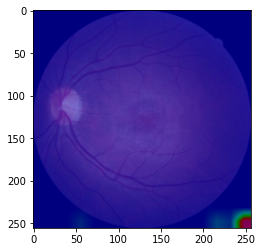

In [ ]:
train_image_dir = os.path.join(DEFAULT_ROOT_DIR, 'train', 'train')
output_image_dir = os.path.join(DEFAULT_ROOT_DIR, 'heatmaps')
if not os.path.exists(output_image_dir):
    os.mkdir(output_image_dir)
for filename in partition[TRAIN_KEY][:20]:
    gradCAM(model, os.path.join(train_image_dir, filename),
            outfile=os.path.join(output_image_dir, '{0}_heatmap.png'.format(
                filename)))

For visualization in jupyter notebook, we'll separate out the calls to gradCAM. These images are also available in the heatmaps directory we've created.

## Normal

[6.3186712e-06 4.7277738e-04 7.3379730e-03]
[]


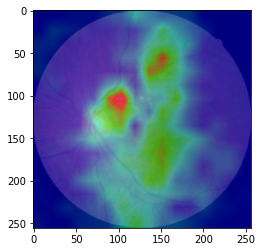

In [ ]:
gradCAM(model, os.path.join(train_image_dir, partition[TRAIN_KEY][0]))

[9.9553007e-01 3.0598032e-06 3.5487723e-03]
['normal']


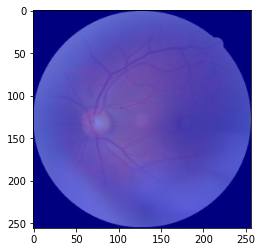

In [ ]:
gradCAM(model, os.path.join(train_image_dir, partition[TRAIN_KEY][2]))

[1.03240245e-05 9.72535491e-01 2.96623376e-03]
['diabetic retinopathy']


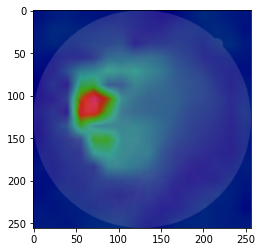

In [ ]:
gradCAM(model, os.path.join(train_image_dir, partition[TRAIN_KEY][30]))

[7.7940204e-10 3.3664599e-04 8.2913266e-07]
[]


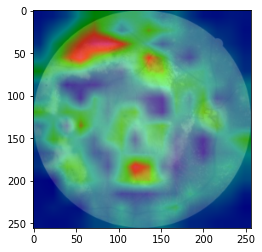

In [ ]:
gradCAM(model, os.path.join(train_image_dir, partition[TRAIN_KEY][35]))

[0.17404343 0.00042518 0.01017108]
[]


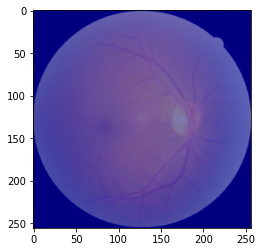

In [ ]:
gradCAM(model, os.path.join(train_image_dir, partition[TRAIN_KEY][37]))

# Diabetic retinopathy

[9.9994886e-01 5.2988421e-06 2.3881651e-07]
['normal']


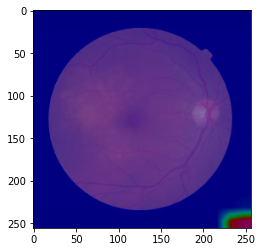

In [ ]:
gradCAM(model, os.path.join(train_image_dir, partition[TRAIN_KEY][3]))

[8.5203278e-10 1.6313429e-01 2.7120126e-05]
[]


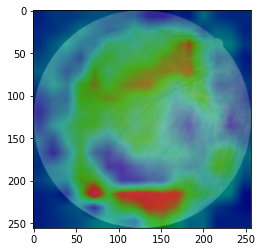

In [ ]:
gradCAM(model, os.path.join(train_image_dir, partition[TRAIN_KEY][13]))

[2.3205514e-06 2.4376079e-03 1.0080636e-03]
[]


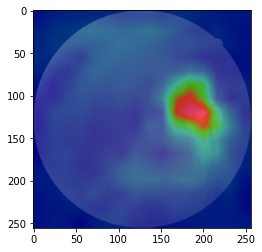

In [ ]:
gradCAM(model, os.path.join(train_image_dir, partition[TRAIN_KEY][15]))

[7.0939874e-05 1.0373366e-04 1.2691296e-02]
[]


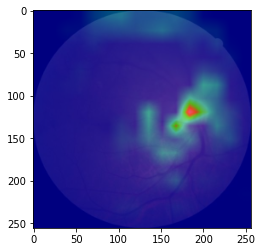

In [ ]:
gradCAM(model, os.path.join(train_image_dir, partition[TRAIN_KEY][16]))

[1.2608870e-05 1.1721893e-06 3.6545519e-02]
[]


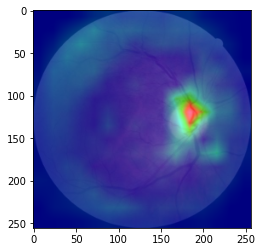

In [ ]:
gradCAM(model, os.path.join(train_image_dir, partition[TRAIN_KEY][22]))

## Glaucoma

[1.000000e+00 7.530336e-12 3.111906e-10]
['normal']


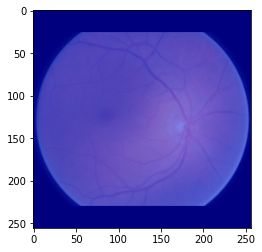

In [ ]:
gradCAM(model, os.path.join(train_image_dir, partition[TRAIN_KEY][9]))

[5.7687771e-08 6.7692124e-03 3.1202827e-02]
[]


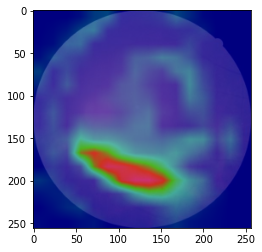

In [ ]:
gradCAM(model, os.path.join(train_image_dir, partition[TRAIN_KEY][11]))

[2.7377498e-13 9.7315490e-01 5.6553778e-05]
['diabetic retinopathy']


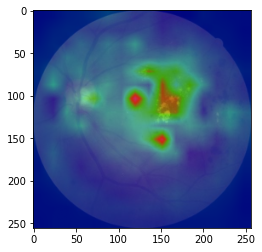

In [ ]:
gradCAM(model, os.path.join(train_image_dir, partition[TRAIN_KEY][20]))

[9.999832e-01 2.194058e-06 6.875332e-07]
['normal']


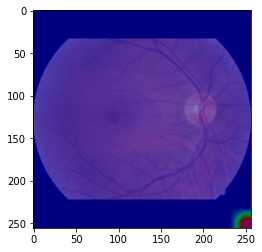

In [ ]:
gradCAM(model, os.path.join(train_image_dir, partition[TRAIN_KEY][42]))

[1.8419176e-08 4.0749484e-04 9.8522834e-04]
[]


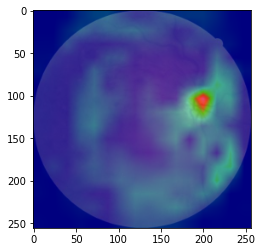

In [ ]:
gradCAM(model, os.path.join(train_image_dir, partition[TRAIN_KEY][51]))

## Analysis

### Normal

Images in this class tend to not cause the model to have high activations at all. The highest activation will be in some arbitrary place in the image, like the corner or some point in the middle of the eye.

### Diabetic retinopathy

The model tends to activate most at the bright spot and the veins protruding from it. This would indicate that those sites are the pathological areas.

### Glaucoma

The model also activates at the bright spot, so there is some indication that this area is of shared interest for both conditions; the model otherwise activates highly around the edges of the eye, indicating that glaucoma could be more associated with sites on the surface.

# Task 3

## Approach

We use the last dense/flatten layer output from the model as a feature set for semi-supervised label spreading to infer labels for the test set. Then we augment the training set with the transduced labels on the test set and improve the performance of our classifier.

In [26]:
def get_last_dense_layer(model: Model) -> Optional[Layer]:
    """Returns the last Dense or Flatten layer in the model.
    :param model: The model.
    :return: The last Dense or Flatten layer, or None if no such layer exists.
    """
    for layer in model.layers[-2::-1]:
        if isinstance(layer, Dense) or isinstance(layer, Flatten):
            return layer
    return None

In [27]:
def get_label_spreading_features(model: Model, filename: str) -> np.ndarray:
    """Returns the value of the model's last Dense or Flatten layer before
    classification on the image at filename.
    :param model: The trained model.
    :param filename: The path to the image.
    :return: The features that will be used in label spreading for filename.
    """
    img_arr = load_image_into_numpy_array(filename)
    norm_img = normalize_image(img_arr)
    x = cv2.resize(norm_img, model.input_shape[1:3])
    x = np.expand_dims(x, axis=0)
    with GradientTape() as tape:
        last_dense_layer = get_last_dense_layer(model)
        iterate = Model([model.inputs], [model.output, last_dense_layer.output])
        model_out, last_dense_layer = iterate(x)
        return last_dense_layer.numpy()[0]

In [28]:
def multilabel_to_int(label: np.ndarray) -> int:
    """Returns the binary multilabel as an int by interpreting it as a bin
    string.
    :param label: The label.
    :return: The int representing that label.
    """
    return int(''.join([str(int(num)) for num in label]), 2)

In [29]:
def int_to_multilabel(num: int, num_classes: int) -> np.ndarray:
    """Returns the multilabel representing the given num.
    :param num: The label integer representation.
    :param num_classes: The number of classes in use. This is used for padding
    the converted label to the correct size.
    :return: The label.
    """
    return np.array([int(bin_digit) for bin_digit in '{0:b}'.format(
        int(num), num_classes).zfill(num_classes)], dtype=np.float32)

In [30]:
def get_label_spreading_dataset(model: Model, partition: Dict[str, List[str]],
                                labels: Dict[str, np.ndarray],
                                root_dir: str) -> (np.ndarray, np.ndarray):
    """Returns the dataset that will be used for label spreading as x, y.
    :param model: The model.
    :param partition: The partition.
    :param labels: The labels.
    :param root_dir: The root directory, under which there are train and test
    subdirectories.
    :return: The label spreading dataset as x, y.
    """
    train_image_dir = os.path.join(root_dir, 'train', 'train')
    test_image_dir = os.path.join(root_dir, 'test', 'test')
    first_img_features = get_label_spreading_features(model, os.path.join(
        train_image_dir, partition[TRAIN_KEY][0]))
    x_train = np.zeros((len(partition[TRAIN_KEY]),
                        first_img_features.shape[0]))
    y_train = np.zeros((len(partition[TRAIN_KEY]),))
    for i, filename in enumerate(partition[TRAIN_KEY]):
        if i % 100 == 0:
            print('Iteration {0}'.format(i))
        x_train[i] = get_label_spreading_features(model, os.path.join(
            train_image_dir, partition[TRAIN_KEY][i]))
        y_train[i] = multilabel_to_int(labels[partition[TRAIN_KEY][i]])
    x_val = np.zeros((len(partition[VAL_KEY]), first_img_features.shape[0]))
    y_val = np.zeros((len(partition[VAL_KEY]),))
    for i, filename in enumerate(partition[VAL_KEY]):
        if i % 100 == 0:
            print('Iteration {0}'.format(i))
        x_val[i] = get_label_spreading_features(model, os.path.join(
            train_image_dir, partition[VAL_KEY][i]))
        y_val[i] = multilabel_to_int(labels[partition[VAL_KEY][i]])
    x_test = np.zeros((len(partition[TRAIN_KEY]),
                        first_img_features.shape[0]))
    y_test = -1 * np.ones((len(partition[TRAIN_KEY]),))
    for i, filename in enumerate(partition[TEST_KEY]):
        if i % 100 == 0:
            print('Iteration {0}'.format(i))
        x_test[i] = get_label_spreading_features(model, os.path.join(
            test_image_dir, partition[TEST_KEY][i]))
    return np.concatenate((x_train, x_val, x_test), axis=0), np.concatenate(
        (y_train, y_val, y_test), axis=0)

In [31]:
def get_y_test_transduced(x_label_spreading: np.ndarray,
                          y_label_spreading: np.ndarray,
                          partition: Dict[str, List[str]],
                          num_classes: int) -> np.ndarray:
    """Returns the transduced labels for the test dataset.
    :param x_label_spreading: The features acquired during label spreading.
    :param y_label_spreading: The labels acquired during label spreading.
    :param partition: The partition.
    :param num_classes: The number of classes.
    :return: The transduced labels for the test set in partition.
    """
    num_labeled_points = len(partition[TRAIN_KEY]) + len(partition[VAL_KEY])
    lp_model = LabelSpreading(gamma=0.25, max_iter=20)
    lp_model.fit(x_label_spreading, y_label_spreading)
    predicted_ints = lp_model.transduction_[num_labeled_points:]
    return np.array([int_to_multilabel(pred, num_classes)
        for pred in predicted_ints])

In [32]:
def get_transduced_partition_and_labels(
    partition: Dict[str, List[str]],
    labels: Dict[str, np.ndarray],
    y_test_transduced: np.ndarray,
    root_dir: str) -> (Dict[str, List[str]], Dict[str, np.ndarray]):
    """Returns the transduced partition and labels for use in training.
    :param partition: The (old) partition.
    :param labels: The (old) labels.
    :param y_test_transduced: The transduced labels.
    :param root_dir: The root directory, under which there are train and test
    subdirectories.
    :return: The transduced partition and labels.
    """
    train_image_dir = os.path.join(root_dir, 'train', 'train')
    test_image_dir = os.path.join(root_dir, 'test', 'test')
    transduced_partition = {}
    transduced_partition[TRAIN_KEY] = [os.path.join(train_image_dir, filename)
        for filename in partition[TRAIN_KEY]] + [os.path.join(
            test_image_dir, filename) for filename in partition[TEST_KEY]]
    transduced_partition[VAL_KEY] = [os.path.join(train_image_dir, filename)
        for filename in partition[VAL_KEY]]
    transduced_labels = {}
    for filename in partition[TRAIN_KEY]:
        transduced_labels[os.path.join(
            train_image_dir, filename)] = labels[filename]
    for filename in partition[VAL_KEY]:
        transduced_labels[os.path.join(
            train_image_dir, filename)] = labels[filename]
    for i, filename in enumerate(partition[TEST_KEY]):
        transduced_labels[os.path.join(
            test_image_dir, filename)] = y_test_transduced[i]
    return transduced_partition, transduced_labels

In [33]:
x_label_spreading, y_label_spreading = get_label_spreading_dataset(
    model, partition, labels, DEFAULT_ROOT_DIR)
print(x_label_spreading.shape)
print(y_label_spreading.shape)
print(np.min(y_label_spreading))
print(np.max(y_label_spreading))

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Iteration 1100
Iteration 1200
Iteration 1300
Iteration 1400
Iteration 1500
Iteration 1600
Iteration 1700
Iteration 1800
Iteration 1900
Iteration 2000
Iteration 2100
Iteration 2200
Iteration 2300
Iteration 2400
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Iteration 0
Iteration 100
Iteration 200
Iteration 300
(5840, 32768)
(5840,)
-1.0
4.0


In [35]:
y_test_transduced = get_y_test_transduced(x_label_spreading, y_label_spreading,
                                          partition, len(DEFAULT_CLASS_NAMES))
print(y_test_transduced.shape)
print(y_test_transduced[:5])
print(np.min(y_test_transduced))
print(np.max(y_test_transduced))

(2405, 3)
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
0.0
1.0


/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


In [36]:
transduced_partition, transduced_labels = get_transduced_partition_and_labels(
    partition, labels, y_test_transduced, DEFAULT_ROOT_DIR)

Found 2755 non-validated image filenames.
Found 1030 non-validated image filenames.
Epoch 1/50
87/87 [==============================] - 51s 541ms/step - loss: 0.3358 - accuracy: 0.4838 - val_loss: 0.2774 - val_accuracy: 0.5204
Epoch 2/50
87/87 [==============================] - 45s 518ms/step - loss: 0.1154 - accuracy: 0.5258 - val_loss: 0.2651 - val_accuracy: 0.5553
Epoch 3/50
87/87 [==============================] - 46s 524ms/step - loss: 0.0747 - accuracy: 0.5322 - val_loss: 0.2455 - val_accuracy: 0.5883
Epoch 4/50
87/87 [==============================] - 47s 534ms/step - loss: 0.0427 - accuracy: 0.5375 - val_loss: 0.1674 - val_accuracy: 0.6068
Epoch 5/50
87/87 [==============================] - 47s 535ms/step - loss: 0.0321 - accuracy: 0.5497 - val_loss: 0.2091 - val_accuracy: 0.5379
Epoch 6/50
87/87 [==============================] - 47s 544ms/step - loss: 0.1001 - accuracy: 0.5353 - val_loss: 0.2479 - val_accuracy: 0.5612
Epoch 7/50
87/87 [==============================] - 47s 54

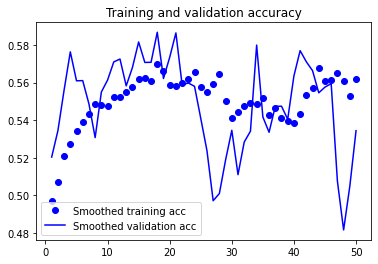

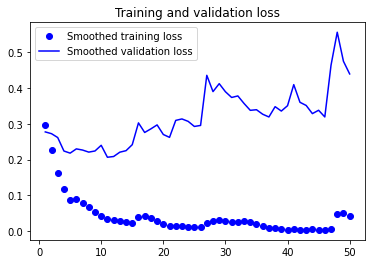

In [37]:
history = train_model(model, transduced_partition, transduced_labels,
                      train_args, None, DEFAULT_CLASS_NAMES)
plot_history(history)

## Label spreading results

As a result of semi-supervised label spreading, our model performance on the validation set improved.

|Model|Train Accuracy|Val Accuracy|
|-|-|-|
|Before label spreading|0.6236|0.5223|
|After label spreading|0.5458|0.6485|

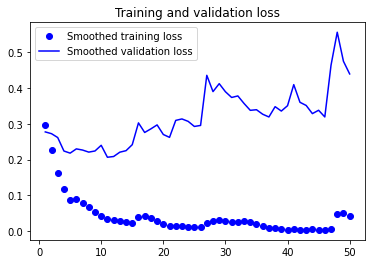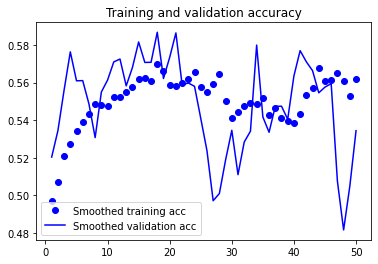

# Conclusion

We made a deep neural network to classify retina scans, used the last layer gradient to find key areas in the activation map, and implemented semi-supervised learning to improve the model's accuracy on the validation set.